C:\Users\KammingaJW\AppData\Local\Temp\ipykernel_33484\3093609692.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


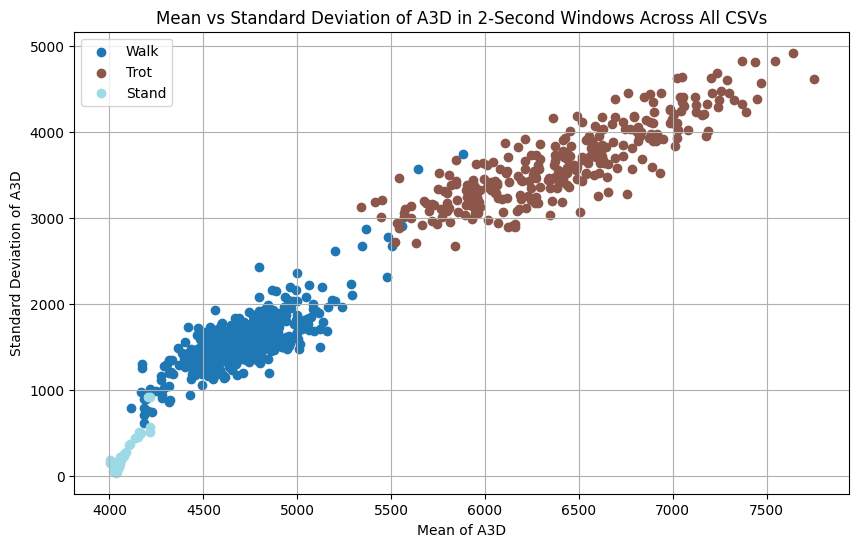

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the folder containing the CSV files
csv_folder_path = 'C:/Users/KammingaJW/Downloads/Horstlinde_export_1/activity_annotations/'

# Path to the JSON file
json_file_path = csv_folder_path+'activity_annotations.json'  # Replace with the path to your JSON file


# Function to calculate windowed statistics for a segment
def calculate_windowed_stats(segment, window_size=2.0, overlap=0.5):
    step_size = window_size * (1 - overlap)
    start_time = segment['Time'].min()
    end_time = segment['Time'].max()

    stats = []
    current_start = start_time
    while current_start + window_size <= end_time:
        current_end = current_start + window_size
        window = segment[(segment['Time'] >= current_start) & (segment['Time'] < current_end)]
        std_dev = window['A3D'].std()
        mean = window['A3D'].mean()
        stats.append({"std_dev": std_dev, "mean": mean})
        current_start += step_size

    return stats


# Load JSON data
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# Process each entry in the JSON data
all_windowed_stats = []
for entry in json_data:
    # Extract CSV file name from JSON entry
    csv_file_name = entry['data']['csv'].split('?')[0]  # Adjust this if the format is different
    csv_file_path = os.path.join(csv_folder_path, csv_file_name)

    # Load CSV data
    csv_data = pd.read_csv(csv_file_path)

    # Parse annotations and calculate windowed statistics
    for annotation in entry["annotations"]:
        for result in annotation["result"]:
            start = result["value"]["start"]
            end = result["value"]["end"]
            label = result["value"]["timeserieslabels"][0]

            segment = csv_data[(csv_data['Time'] >= start) & (csv_data['Time'] <= end)]
            stats = calculate_windowed_stats(segment)
            for stat in stats:
                stat['label'] = label
                all_windowed_stats.append(stat)

# Preparing data for scatter plot
means = [stat['mean'] for stat in all_windowed_stats]
std_devs = [stat['std_dev'] for stat in all_windowed_stats]
labels = [stat['label'] for stat in all_windowed_stats]

# Scatter plot with distinct colors
unique_labels = list(set(labels))
colors = plt.cm.get_cmap('tab20', len(unique_labels))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idx = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(np.array(means)[idx], np.array(std_devs)[idx], label=label, color=colors(i))

plt.title("Mean vs Standard Deviation of A3D in 2-Second Windows Across All CSVs")
plt.xlabel("Mean of A3D")
plt.ylabel("Standard Deviation of A3D")
plt.legend()
plt.grid(True)
plt.show()
